# ANN - CNN - Pneumonia Diagnosis

# Introduction

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of paediatric patients aged one to five years from the Guangzhou Women's and Children's Medical Centre, Guangzhou. All chest X-ray images were performed as part of the patients' routine clinical care.

For analysis of the chest X-ray images, all chest X-rays were initially reviewed for quality control by removing all low-quality or unreadable scans. Then, two expert physicians graded the diagnostic images before authorising them to train the AI system. To account for any grading errors, the evaluation set was also verified by a third expert.

Information on the project can be found at the link Links to an external [site](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

The dataset (also available in the folder Resources Module 5) is organised in 3 folders (training, test, val) and contains subfolders for each image category (pneumonia/normal). There are 5,863 X-ray images (in JPEG format) and 2 categories (pneumonia/normal). 

The data have been extracted from kaggle, you can find them at the following link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumoniaLinks to an external site.

__Please note__: you must maintain the structure of the train, test and val folders with the same files included in each folder.

## 1. Import libraries

In [124]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import keras.utils as image

from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

__Please note__: define below the string variables with the path to the image folders. Example of relative path below.

In [26]:
pathsample='../CNN/chest_xray/val/NORMAL/'
pathtrain='../CNN/chest_xray/train'
pathtest='../CNN/chest_xray/test'
pathval='../CNN/chest_xray/val'

## 2. Adjust CNN to the images to be trained

Load a sample image to visually check what we are working with, as well as the size of the image and the number of channels, in this case 3, of course (RGB).

(1040, 1272, 3)


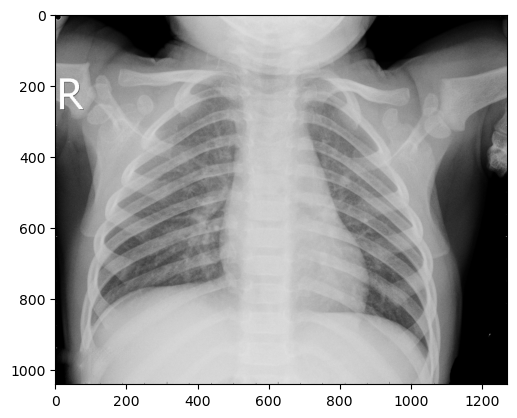

In [21]:
img_path = pathsample + 'NORMAL2-IM-1430-0001.jpeg'
img = image.load_img(img_path)
img_tensor = image.img_to_array(img)
print(img_tensor.shape)

plt.imshow(img)
plt.show()

We do not have a large image dataset (<100K), for that reason we will use Data Augmentation techniques through __ImageDataGenerator__, which will allow us to avoid overfitting

## 3. Build CNN

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255, # scale/normalise the colours of the pixels and obtain values between 0 and 1 (as long as we work with RGB uint8).
        shear_range=0.2, # 20% rotation angle. Will rotate between -20% and +20%.
        zoom_range=0.2, # data augmentation by 20%. It will zoom in up to 1.2 and zoom out up to 0.8.
        rotation_range=20,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(pathtrain,
                                                    target_size=(64, 64),
                                                    batch_size=32,
                                                    class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(pathtest,
                                                target_size=(64, 64),
                                                batch_size=32,
                                                class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We apply Rescale dividing by 255 since the image is a jpg (it is an 8bit format. 2^8 = 256 possible intensity values) and we also check it in the "Details" section of the image.

We apply Shear Range and Zoom Range of 20%, although it is true that the type of image we are working with is taken following a strict protocol that presents little variability on these two parameters. In any case, what we are looking for is to avoid overfitting, so we maintain the initial criteria.

Initialise the network

In [5]:
classifier = Sequential()

Create the convolution layer

In [6]:
classifier.add(Conv2D(filters = 32, # Number of filters to apply, multiple of 2 (2^5)
                      kernel_size = (3, 3), # Filter size
                      input_shape = (64, 64, 3), # Input size of the photos and whether it is in colour or not (3 is the number of channels)
                      activation = "relu", # Activation function
                      strides=(1,1)) # Vertical and horizontal jumps/movements of the 3x3 kernel/filter matrix defined above
                      )
classifier.output_shape

(None, 62, 62, 32)

Before we continue, let's check Nº Parameters of each image or input.

* Nº Parameters: (((3 * 3 * 3)+1) * 32)/1= 896. 

This is equivalent to: filter width (3) x filter height (3) x no. of previous filters (we had 3 channels in the input images) + filter offset (1) x no. of filters in this layer (32) / stride of the filter matrix or kernel (1).

Now we add the Pooling layer to reduce the dimensionality of the Feature Map obtained from the convolution layer.
We will use a 2x2 matrix and a MaxPooling2D, extracting the maximum value of each matrix, which in this case, when dealing with images, we choose 2D.

In [7]:
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.output_shape

(None, 31, 31, 32)

Although, the examples reviewed in the network, usually have no less than 2 layers of convolution and its 2 layers of Pooling, applied in series. In this example we are only going to use one, in order to speed up the training and, therefore, to check other variables in play in the model.

Once the CNN phase is finished, and before introducing our data in the DNN phase (fully-connected layer), we are going to "flatten" the data, generating a series (1D), through a Flatten layer. This is an indispensable step to deliver the data in the dimensionality required by the Dense layer.
We will also add a Dropout layer, which will randomly turn off 50% of the network in each epoch, to avoid overfitting.

In [8]:
classifier.add(Flatten())
classifier.output_shape

(None, 30752)

Let's check the number of parameters we have in the DNN entry.

* Nº Parameters: 31 * 31 * 32 = 30.752

See that we have 30,752 input variables + 1 output variable, making a total of 30,753.
If we follow the recommendations/good practices advised by experts for conventional DNN, we should define 15,376 units/neurons, this being the half. However, this is a large number, which would result in 472,858,128 parameters (30,753 * 15,376). 

We therefore follow the recommendations that I have been able to find out in different forums, where it is recommended to apply the square root of the number of parameters coming from CNN to the DNN layer coming from CNN. In this case, the root of 30,752 = 175.

This results in:

* Nº Parameters: 30.752 * 175 = 5.381.600

In [9]:
classifier.add(Dropout(0.5))

In [10]:
classifier.add(Dense(units = 175, activation = "relu"))
classifier.add(Dense(units = 1, activation = "sigmoid"))

## 4. Compile and train

In the compilation phase of the previously created structure. For the gradient descent optimiser, in its second derivative approximation, we will use the Adam (Adaptive Moment Estimation) method.  It is a combination of RMSProp with Momentum. On the one hand we will have the exponential moving average of the squared gradient, and on the other hand the exponential moving average of the previous steps. It is usually faster than RMSProp.

For the loss function, being a classification problem, we use the Cross Entropy function.

For the metrics, ditto the previous criterion, we use Accuracy.

In [13]:
classifier.compile(optimizer = "Adam", 
                   loss = "binary_crossentropy", 
                   metrics = ["accuracy"])

In [17]:
history = classifier.fit(training_dataset,
                        steps_per_epoch = training_dataset.n//32,#5216/32=163 (valor del batch_size),
                        epochs=70,
                        validation_data=testing_dataset,
                        validation_steps=testing_dataset.n//32 #624/32=19
                        )

Epoch 1/70
163/163 [==============================] - 75s 459ms/step - loss: 0.1227 - accuracy: 0.9557 - val_loss: 0.2858 - val_accuracy: 0.9243
Epoch 2/70
163/163 [==============================] - 75s 461ms/step - loss: 0.1259 - accuracy: 0.9546 - val_loss: 0.2776 - val_accuracy: 0.9112
Epoch 3/70
163/163 [==============================] - 76s 465ms/step - loss: 0.1331 - accuracy: 0.9488 - val_loss: 0.3162 - val_accuracy: 0.9293
Epoch 4/70
163/163 [==============================] - 75s 460ms/step - loss: 0.1174 - accuracy: 0.9534 - val_loss: 0.5332 - val_accuracy: 0.8865
Epoch 5/70
163/163 [==============================] - 73s 448ms/step - loss: 0.1178 - accuracy: 0.9551 - val_loss: 0.3420 - val_accuracy: 0.9243
Epoch 6/70
163/163 [==============================] - 72s 444ms/step - loss: 0.1199 - accuracy: 0.9553 - val_loss: 0.3122 - val_accuracy: 0.9178
Epoch 7/70
163/163 [==============================] - 73s 449ms/step - loss: 0.1274 - accuracy: 0.9503 - val_loss: 0.4141 - val_ac

## 5. Validation

Avg. Train Accuracy:  96.1
Avg. Test Accuracy:   91.60000000000001
Avg. Train Loss:  10.4
Avg. Test Loss:   36.27


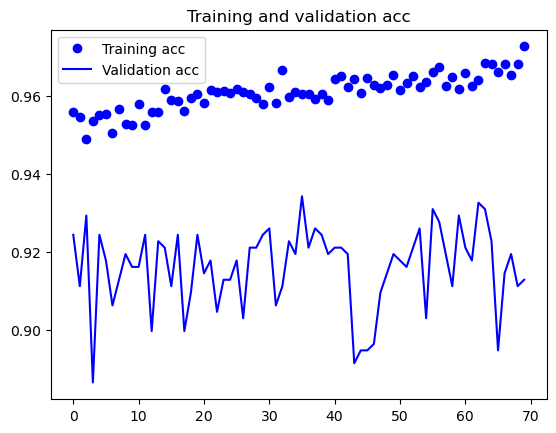

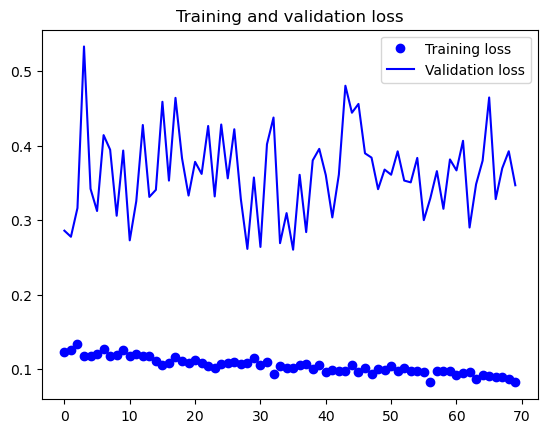

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('Avg. Train Accuracy: ',round(np.mean(acc),3)*100)
print('Avg. Test Accuracy:  ',round(np.mean(val_acc),4)*100)
print('Avg. Train Loss: ',round(np.mean(loss),3)*100)
print('Avg. Test Loss:  ',round(np.mean(val_loss),4)*100)
epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
print('Accuracy sobre conjunto de training: ', round(np.mean(acc)*100,2))
print('Accuracy sobre conjunto de test: ', round(np.mean(val_acc)*100,2))

Accuracy sobre conjunto de training:  96.09
Accuracy sobre conjunto de test:  91.6


We have a model that we could consider as good, being above 75-80% of Accuracy.

It is important to mention that the value of Loss Function and Accuracy on the test dataset maintains a stable average throughout the successive epochs; on the other hand, these results improve with the passing of the epochs in the case of train. Therefore, we can observe that with this structure applied on this dataset, increasing the number of epochs will not improve the prediction, but on the contrary, it will increase the overfitting of the model.

## 6. Prediction over new samples

We are going to classify two photos that the network has not seen to check what output it gives us, to do this we create a loop for each of the photos in the prediction folder by doing the following steps:

In [115]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_dataset=val_datagen.flow_from_directory(pathval,
                                            target_size=(64, 64),
                                            class_mode='binary',
                                            shuffle=False)

Found 16 images belonging to 2 classes.


In [116]:
true_classes = val_dataset.classes>0.5
print(true_classes)
print(np.unique(np.array(true_classes),return_counts=True))
class_labels = list(val_dataset.class_indices.keys())
print(class_labels)

[False False False False False False False False  True  True  True  True
  True  True  True  True]
(array([False,  True]), array([8, 8], dtype=int64))
['NORMAL', 'PNEUMONIA']


In [117]:
predictions=classifier.predict(val_dataset)>0.5
print(predictions.flatten())
print(np.unique(np.array(predictions),return_counts=True))

1/1 [==============================] - 0s 178ms/step
[False False False False False False False False  True  True  True False
  True  True  True  True]
(array([False,  True]), array([9, 7], dtype=int64))


In [118]:
report = metrics.classification_report(true_classes, predictions, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      NORMAL       0.89      1.00      0.94         8
   PNEUMONIA       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



Being a prediction of a disease, we are interested in the Recall value, that is, we are interested in identifying all cases of pneumonia even with the risk of obtaining a false positive. We see that 1 case of pneumonia has not been able to be identified, which with such a small validation dataset, makes the Recall value drop to 88%.

We can conclude that this is a good model as long as, of course, we have a human validator to do the final filtering on the diagnosis.

## 7. Heatmap

It seems interesting to be able to check the activation zones resulting from the convolution and plot them. A very powerful visual tool to check in a human way the result/criteria applied by the network. Below is the result of this exercise.

Source of the code: https://keras.io/examples/vision/grad_cam/

In [126]:
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.cm as cm

Let's use a positive example in pneumonia.

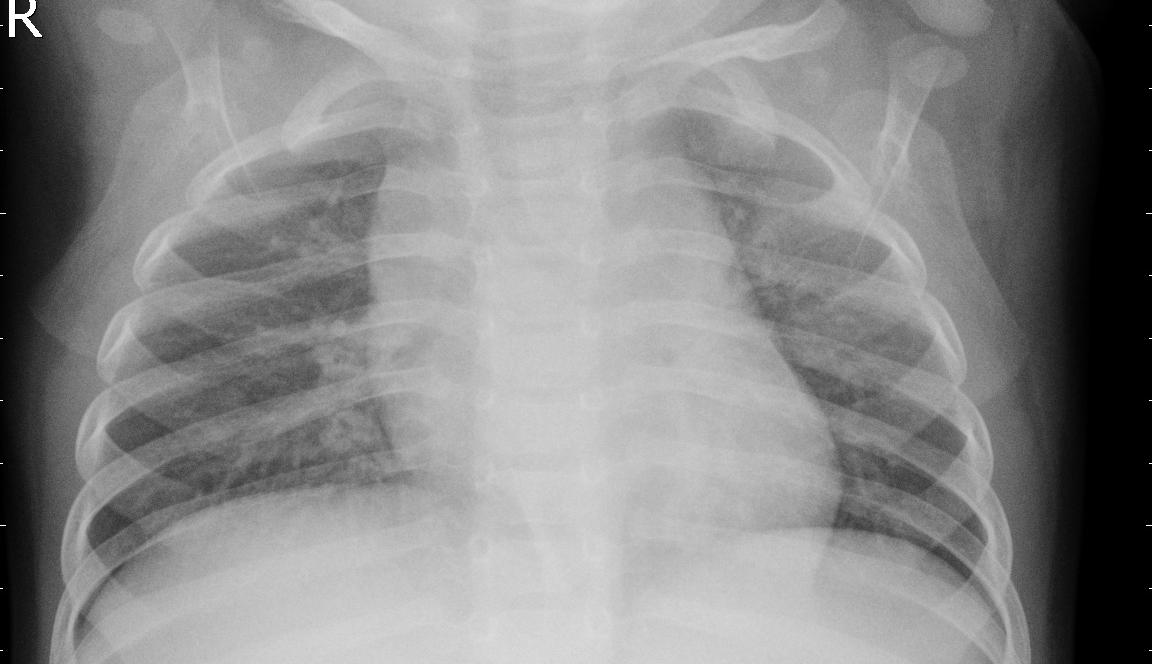

In [215]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act" 

# The local path to our target image
img_path = '../Caso Practico/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'

display(Image(img_path))

In [168]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 1s/step
Predicted: [('n04040759', 'radiator', 5.6606827)]


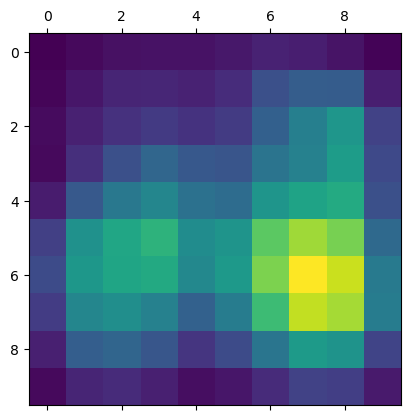

In [216]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

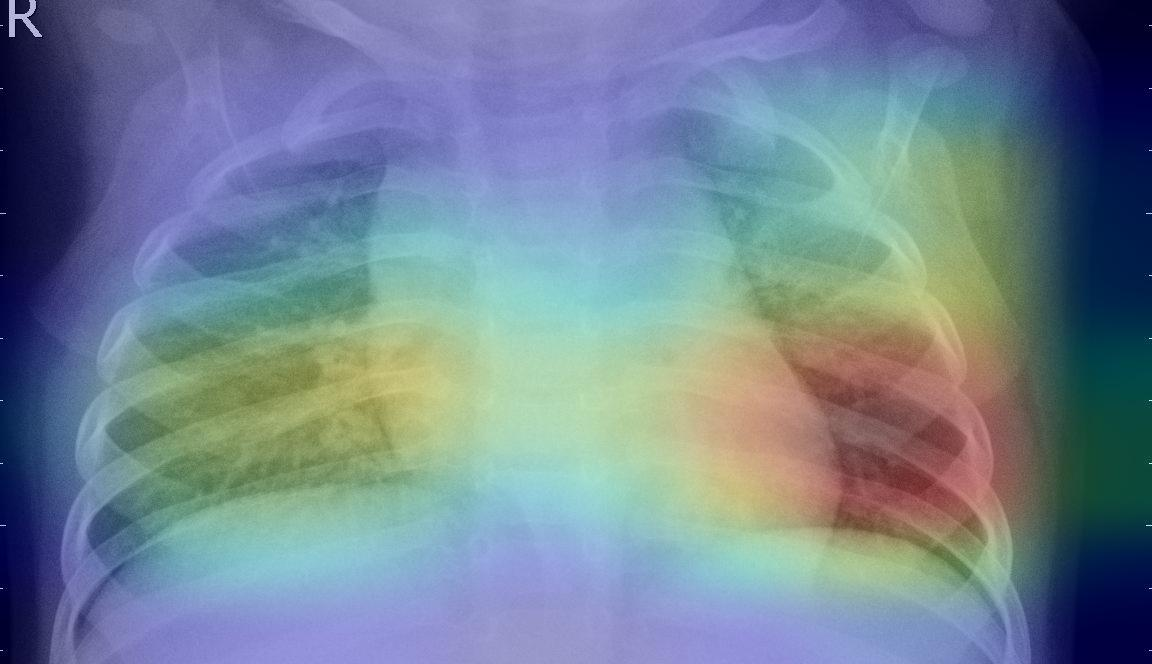

In [218]:
def save_and_display_gradcam(img_path, heatmap, path="heatmap_pneumonia_sample.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(path)

    # Display Grad CAM
    display(Image(path))


save_and_display_gradcam(img_path, heatmap)